In [1]:
from src.utils.construct_map import construct_map
from src.utils.tsp_solver import k_opt
from src.visualization.paths_and_subtours import visualize_subtours
from concurrent.futures import ProcessPoolExecutor
from scipy.spatial import distance
from typing import Dict
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from src.visualization.visualization_pipeline import run_visualization_pipeline


In [2]:
# Chose number of robots
k = 8
# Chose the number of targets in an axis (NOT NUMBER OF TOTAL NODES)
n = 8  # 64 nodes in total
# Chose the length of distance of each side of the square arena
d = 3.
# Choose the redundancy parameter (have each target be visited by exactly that many robots)
rp = min(3, k)
# Fuel Capacity Parameters
max_fuel_cost_to_node = d * np.sqrt(2)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
L_min = max_fuel_cost_to_node * 2  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
L = L_min * 1.5  # Fuel capacity (1 unit of fuel = 1 unit of distance)

skip_tsp_optimization = False

## 1. Create map and get node indices


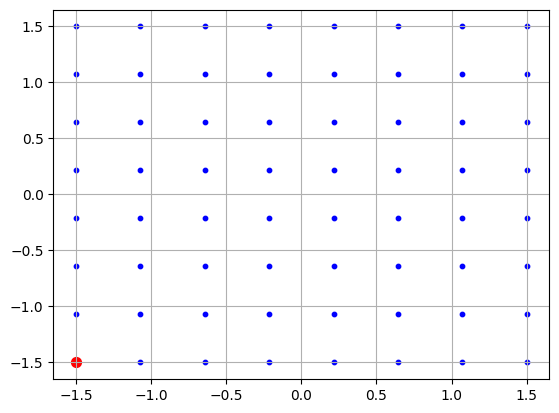

In [3]:
# 1. Create map and get node indices
nodes, node_indices, target_indices, depot_indices = construct_map(n, d, gfx_sanity_check=True)

## 2. Calculate cost between each node


In [4]:
# 2. Calculate cost between each node
start = time.time()
cost = distance.cdist(nodes, nodes, 'euclidean')

print(f"took {time.time() - start} seconds")
print(f"{cost.shape=}")

took 0.00011301040649414062 seconds
cost.shape=(65, 65)


## 3. Solve for given parameters

Step 1 took 0.0005049705505371094 seconds.


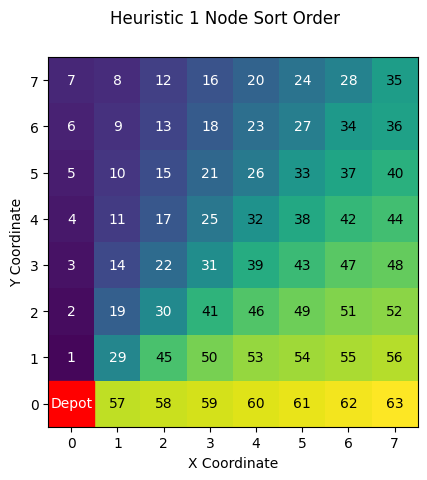

In [5]:
# Step 1: sort the node indices for creating subtours
start = time.time()
heading_values = []
for n_i in target_indices:
    v1 = nodes[n_i]
    v2 = nodes[depot_indices[0]]
    heading = np.arctan2(*(v1 - v2)) % (2 * np.pi)
    heading_values.append(heading)
heading_values = np.array(heading_values)
# print(f"{heading_values.shape=}")
nodes_costs = cost[:depot_indices[0], depot_indices[0]]
# print(f"{nodes_costs.shape=}")
sorted_indices = np.lexsort((nodes_costs, heading_values))
# for i, ni in enumerate(sorted_indices):
#     print(f"{i=} {ni=} {heading_values[ni]=} {nodes_costs[ni]=}")
print(f"Step 1 took {time.time() - start} seconds.")
# Step 1 visualization
sort_map = np.zeros((n, n))
for i, ni in enumerate(sorted_indices):
    sort_map[int(np.floor(ni / n)), int(ni) % n] = i
fig, ax = plt.subplots()
pos = plt.imshow(sort_map.T, origin='lower')
ax.add_patch(plt.Rectangle((-0.5, -0.5), 1, 1, color='r'))
plt.text(0, 0, "Depot", ha="center", va="center", color="w")
for (i, j), label in np.ndenumerate(sort_map):
    if i == j == 0: continue
    tc = "white" if sort_map[i, j] < sort_map.mean() else "black"
    plt.text(i, j, f"{int(sort_map[i, j])}", ha="center", va="center", color=tc)
fig.suptitle("Heuristic 1 Node Sort Order")
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


In [6]:
def divideArrayByP(maxp, countf, low, high, force_p_equals=False):
    # condition = True
    maxSum = low
    maxSum_max = high
    maxSum_min = low
    err_thresh = 0.01
    best_p, best_p_a, best_p_c, best_max_p_c = np.inf, None, [np.inf], np.inf
    # print(f"{best_p=}")
    # Ensure maxp is big enough
    while True:
        p, p_a, p_c, max_p_c = countf(high, maxp)
        if p == np.inf:
            maxp += 1
        else:
            break

    # Try to reduce maxSum now (cost of each subtour)
    while True:
        p, p_a, p_c, max_p_c = countf(maxSum, maxp)
        # print(f"2 {maxp=} {best_p=} {maxSum=} {maxSum_min=} {maxSum_max=}")
        # If we can't divide it to the number of robots we have, increase by one
        if best_p == np.inf and maxSum_max - maxSum_min < err_thresh:
            maxp += 1
            maxSum = low
            maxSum_min = low
            maxSum_max = high

        if p > maxp:
            maxSum_min = maxSum
        elif p <= maxp:
            maxSum_max = min(max_p_c, maxSum_max)
            maxSum = max_p_c

        if (force_p_equals and maxp >= p and max_p_c <= best_max_p_c) or (not force_p_equals and p <= best_p):
            best_p = p
            best_p_a = p_a
            best_p_c = p_c
            best_max_p_c = max_p_c

        # print(f"{p=} {best_p=} {maxSum=} {maxSum_min=} {maxSum_max=} {maxSum_max - maxSum_min=} {max_p_c=} {p_c=}")
        # print(f"{p=} {p_a=} {p_c=}")
        # time.sleep(0.5)

        if best_p <= maxp and maxSum_max - maxSum_min < err_thresh:
            return best_p_a, best_p_c, maxSum

        if p > maxp and maxSum <= high:
            delta = maxSum_max - maxSum
            maxSum = maxSum + delta / 2.
        else:
            delta = maxSum - maxSum_min
            maxSum = maxSum - delta / 2.


Step 2: Found 7 subtours.
Step 2 took 0.0007128715515136719 seconds.


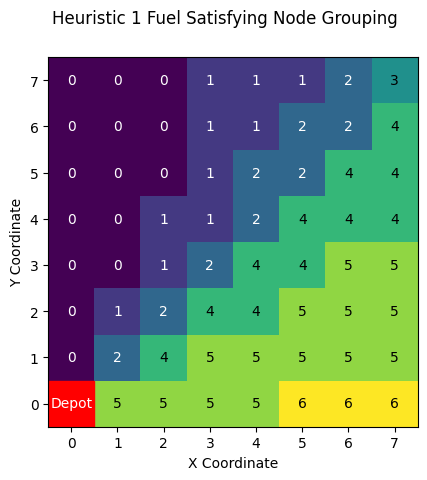

In [7]:
# Step 2: Divide nodes to subtours s.t. cost <= L
start = time.time()

# https://takeuforward.org/arrays/split-array-largest-sum/
def countSubtourPartitions(maxSum, maxp):
    # n = len(a)  # size of array
    partitions = 1
    partitions_array = [[depot_indices[0], depot_indices[0]]]
    partitions_cost = []
    max_partitions_cost = 0
    for i, n_i in enumerate(sorted_indices):
        node_addition_index = 1
        node_addition_cost = np.inf
        subarraySum = 0
        for j, n_j in enumerate(partitions_array[partitions - 1][:-1]):
            n_k = partitions_array[partitions - 1][j + 1]
            edge_cost = cost[n_j, n_k]
            subarraySum += edge_cost
            new_edge_cost = cost[n_j, n_i] + cost[n_i, n_k]
            if new_edge_cost - edge_cost < node_addition_cost:
                node_addition_cost = new_edge_cost - edge_cost
                node_addition_index = j + 1

        if subarraySum + node_addition_cost >= maxSum:
            # if not, insert element to next subarray
            partitions += 1
            if partitions > maxp:
                # print(f"\tearly stopping...")
                return np.inf, None, None, np.inf

            partitions_cost.append(subarraySum)
            max_partitions_cost = max(max_partitions_cost, subarraySum)
            node_addition_index = 1
            partitions_array.append([depot_indices[0], depot_indices[0]])
        partitions_array[partitions - 1].insert(node_addition_index, n_i)
        # print(f"{partitions_array[partitions-1]}")

    if len(partitions_array) != len(partitions_cost):
        subarraySum = 0
        for j, n_j in enumerate(partitions_array[partitions - 1][:-1]):
            n_k = partitions_array[partitions - 1][j + 1]
            subarraySum += cost[n_j, n_k]
        partitions_cost.append(subarraySum)
        max_partitions_cost = max(max_partitions_cost, subarraySum)

    return partitions, partitions_array, partitions_cost, max_partitions_cost

tsp_subtours, tsp_costs, maxSum = divideArrayByP(k, countSubtourPartitions, low=L_min, high=L)
print(f"Step 2: Found {len(tsp_subtours)} subtours.")
# print(f"{L=}")
# print(f"{len(tsp_subtours)=} {maxSum=}")
# print(f"{distributed_nodes_indices=}")
# print(f"{tsp_upper_bound=}")
# visualize_subtours(tsp_subtours, {"n_a": n, "ssd": d, "is_subtour": True})
print(f"Step 2 took {time.time() - start} seconds.")
# Step 2 visualization
node_partition_map = np.zeros((n, n))
for c, si in enumerate(tsp_subtours):
    for i, ni in enumerate(si):
        if ni == 64: continue  # Depot
        node_partition_map[int(np.floor(ni / n)), int(ni) % n] = c
fig, ax = plt.subplots()
pos = plt.imshow(node_partition_map.T, origin='lower')
ax.add_patch(plt.Rectangle((-0.5, -0.5), 1, 1, color='r'))
plt.text(0, 0, "Depot", ha="center", va="center", color="w")
for (i, j), label in np.ndenumerate(node_partition_map):
    if i == j == 0: continue
    tc = "white" if node_partition_map[i, j] < node_partition_map.mean() else "black"
    plt.text(i, j, f"{int(node_partition_map[i, j])}", ha="center", va="center", color=tc)

fig.suptitle("Heuristic 1 Fuel Satisfying Node Grouping")
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()



	[subtour 2/7] took 0.356 seconds and improved 3.954%.
	[subtour 5/7] took 0.463 seconds and improved 0.803%.
	[subtour 7/7] took 0.463 seconds and improved 0.000%.
	[subtour 1/7] took 0.463 seconds and improved 4.315%.
	[subtour 4/7] took 0.463 seconds and improved 0.000%.
	[subtour 3/7] took 0.463 seconds and improved 0.000%.
	[subtour 6/7] took 0.463 seconds and improved 6.295%.
Step 3 took 0.48558497428894043 seconds.
Visualizing paths for heuristic 1 or MILP


7it [00:00, 102.61it/s]


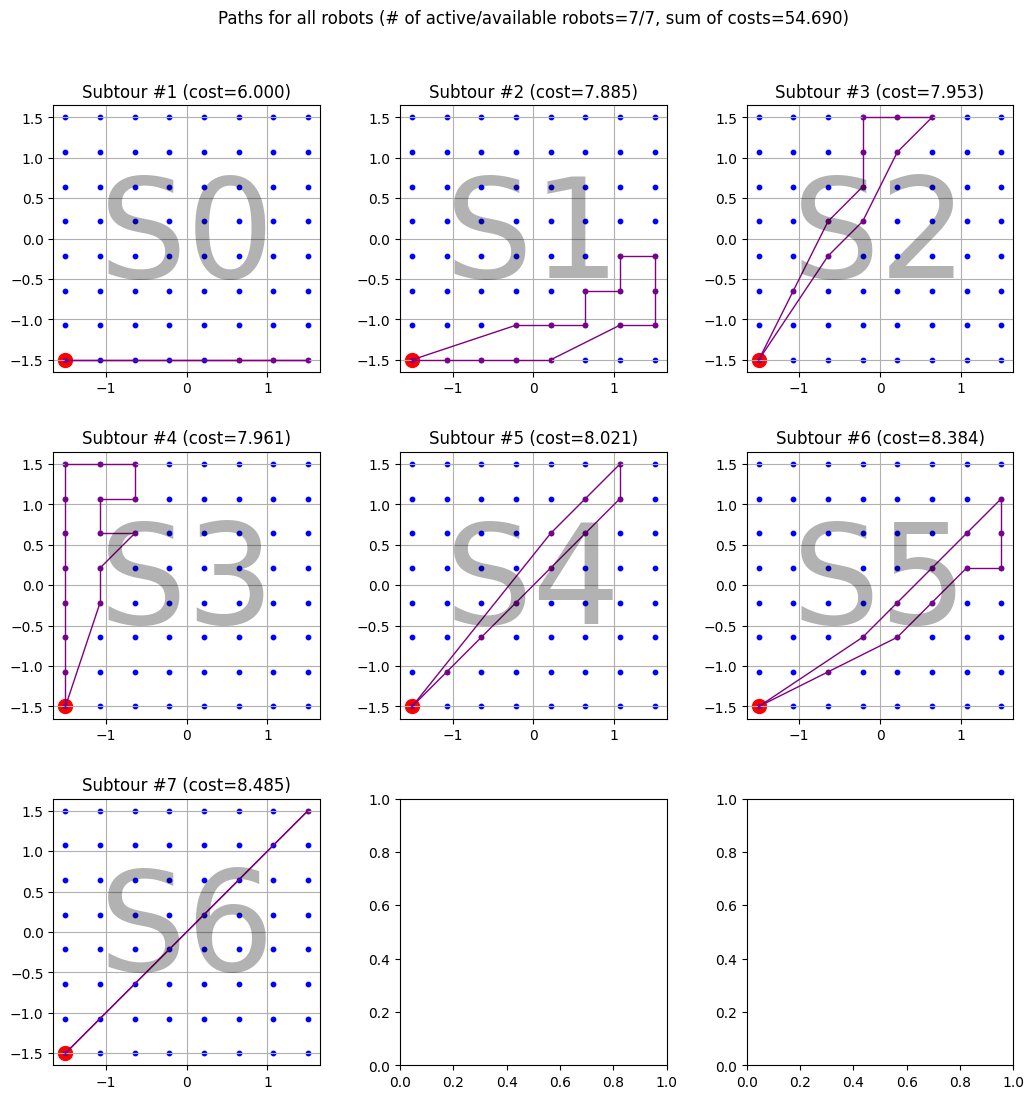

In [8]:
# Step 3: Further optimize the subtours by running tsp on them
if skip_tsp_optimization:
    print(f"Skipping TSP optimization ...")
else:
    start = time.time()
    tsp_subtours_prev, tsp_costs_prev = tsp_subtours, tsp_costs
    tsp_subtours = []
    tsp_costs = []
    with ProcessPoolExecutor(max_workers=os.cpu_count() - 1) as executor:
        futures = []
        for heur_subtour in tsp_subtours_prev:
            futures.append(executor.submit(k_opt, *[heur_subtour, cost, 2]))

        uncompleted_jobs = list(range(len(futures)))
        while len(uncompleted_jobs) != 0:
            new_uncompleted_jobs = uncompleted_jobs
            for future_i in uncompleted_jobs:
                if futures[future_i].done():
                    best_subtour, c = futures[future_i].result()
                    print(
                        f"\t[subtour {future_i + 1}/{len(futures)}] took {time.time() - start:.3f} seconds and improved {(1 - c / tsp_costs_prev[future_i]) * 100:.3f}%.")
                    tsp_subtours.append(best_subtour)
                    tsp_costs.append(c)
                    new_uncompleted_jobs.remove(future_i)
                else:
                    time.sleep(0.1)
            uncompleted_jobs = new_uncompleted_jobs

    tsp_indices = np.array(tsp_costs).argsort().tolist()
    print(f"Step 3 took {time.time() - start} seconds.")
    visualize_subtours([tsp_subtours[tsp_indices[si]] for si in range(len(tsp_subtours))], {"n_a": n, "ssd": d, "is_subtour": True})


In [9]:
# Step 4: Ensure rp
start = time.time()
num_of_subtours = len(tsp_subtours)
rp = max(int(np.ceil(k / num_of_subtours)), rp)
for i in range(num_of_subtours, int(num_of_subtours * rp)):
    tsp_subtours.append(tsp_subtours[i % num_of_subtours])
    tsp_costs.append(tsp_costs[i % num_of_subtours])
    tsp_indices.append(i)
print(f"Step 4 took {time.time() - start} seconds.")


Step 4 took 6.794929504394531e-05 seconds.


In [10]:
# Step 5: Divide subtours between robots
start = time.time()

def countRobotPartitions(maxSum, maxp):
    # n = len(a)  # size of array
    partitions = 1
    subarraySum = 0
    partitions_array = [[]]
    partitions_cost = []
    max_partitions_cost = 0
    for i in tsp_indices:
        if subarraySum + tsp_costs[i] <= maxSum:
            # insert element to current subarray
            subarraySum += tsp_costs[i]
        else:
            # if not, insert element to next subarray
            partitions += 1
            if partitions > maxp:
                # print(f"\tearly stopping...")
                return np.inf, None, None, np.inf

            partitions_cost.append(subarraySum)
            max_partitions_cost = max(max_partitions_cost, subarraySum)
            subarraySum = tsp_costs[i]
            partitions_array.append([])
        partitions_array[partitions - 1].append(tsp_subtours[i])

    if len(partitions_array) != len(partitions_cost):
        partitions_cost.append(subarraySum)
        max_partitions_cost = max(max_partitions_cost, subarraySum)

    return partitions, partitions_array, partitions_cost, max_partitions_cost

# TODO: A better estimate for high could be given to speed up binary search
opt_node_paths, opt_node_path_costs, maxSum = divideArrayByP(k, countRobotPartitions, low=max(tsp_costs),
                                                             high=sum(tsp_costs), force_p_equals=True)
# for i, optimized_node_path in enumerate(opt_node_paths):
#     print(f"[{i}] {len(optimized_node_path)=} cost=({optimized_node_path_costs[i]})")
# print(f"{sum(opt_node_path_costs)=} {max(opt_node_path_costs)=}")
opt_world_paths = []
for ki in range(min(k, len(opt_node_paths))):
    robot_world_path = []
    for i, subtour in enumerate(opt_node_paths[ki]):
        print(f"Assigned subtour {i} to robot {ki}")
        robot_world_path.append(nodes[subtour].tolist())
    opt_world_paths.append(robot_world_path)
print(f"Step 5 took {time.time() - start} seconds.")


Assigned subtour 0 to robot 0
Assigned subtour 1 to robot 0
Assigned subtour 2 to robot 0
Assigned subtour 0 to robot 1
Assigned subtour 1 to robot 1
Assigned subtour 2 to robot 1
Assigned subtour 0 to robot 2
Assigned subtour 1 to robot 2
Assigned subtour 0 to robot 3
Assigned subtour 1 to robot 3
Assigned subtour 2 to robot 3
Assigned subtour 0 to robot 4
Assigned subtour 1 to robot 4
Assigned subtour 0 to robot 5
Assigned subtour 1 to robot 5
Assigned subtour 2 to robot 5
Assigned subtour 0 to robot 6
Assigned subtour 1 to robot 6
Assigned subtour 2 to robot 6
Assigned subtour 0 to robot 7
Assigned subtour 1 to robot 7
Step 5 took 0.0014069080352783203 seconds.


Running visualization pipeline...
Robot node path:  [[[64, 56, 48, 40, 64, 64], [64, 25, 33, 41, 42, 50, 51, 59, 58, 57, 49, 32, 24, 16, 8, 64, 64], [64, 10, 20, 29, 30, 31, 39, 47, 38, 28, 19, 64, 64]], [[64, 1, 2, 3, 4, 5, 6, 7, 15, 23, 22, 14, 13, 21, 12, 11, 0, 64, 64], [64, 9, 18, 27, 36, 45, 54, 55, 46, 37, 64, 64], [64, 26, 35, 44, 53, 62, 61, 60, 52, 43, 34, 17, 64, 64]], [[64, 63, 64, 64], [64, 10, 20, 29, 30, 31, 39, 47, 38, 28, 19, 64, 64]], [[64, 26, 35, 44, 53, 62, 61, 60, 52, 43, 34, 17, 64, 64], [64, 56, 48, 40, 64, 64], [64, 1, 2, 3, 4, 5, 6, 7, 15, 23, 22, 14, 13, 21, 12, 11, 0, 64, 64]], [[64, 63, 64, 64], [64, 9, 18, 27, 36, 45, 54, 55, 46, 37, 64, 64]], [[64, 25, 33, 41, 42, 50, 51, 59, 58, 57, 49, 32, 24, 16, 8, 64, 64], [64, 10, 20, 29, 30, 31, 39, 47, 38, 28, 19, 64, 64], [64, 26, 35, 44, 53, 62, 61, 60, 52, 43, 34, 17, 64, 64]], [[64, 56, 48, 40, 64, 64], [64, 1, 2, 3, 4, 5, 6, 7, 15, 23, 22, 14, 13, 21, 12, 11, 0, 64, 64], [64, 63, 64, 64]], [[64, 9, 18, 27, 36

8it [00:00, 46.33it/s]


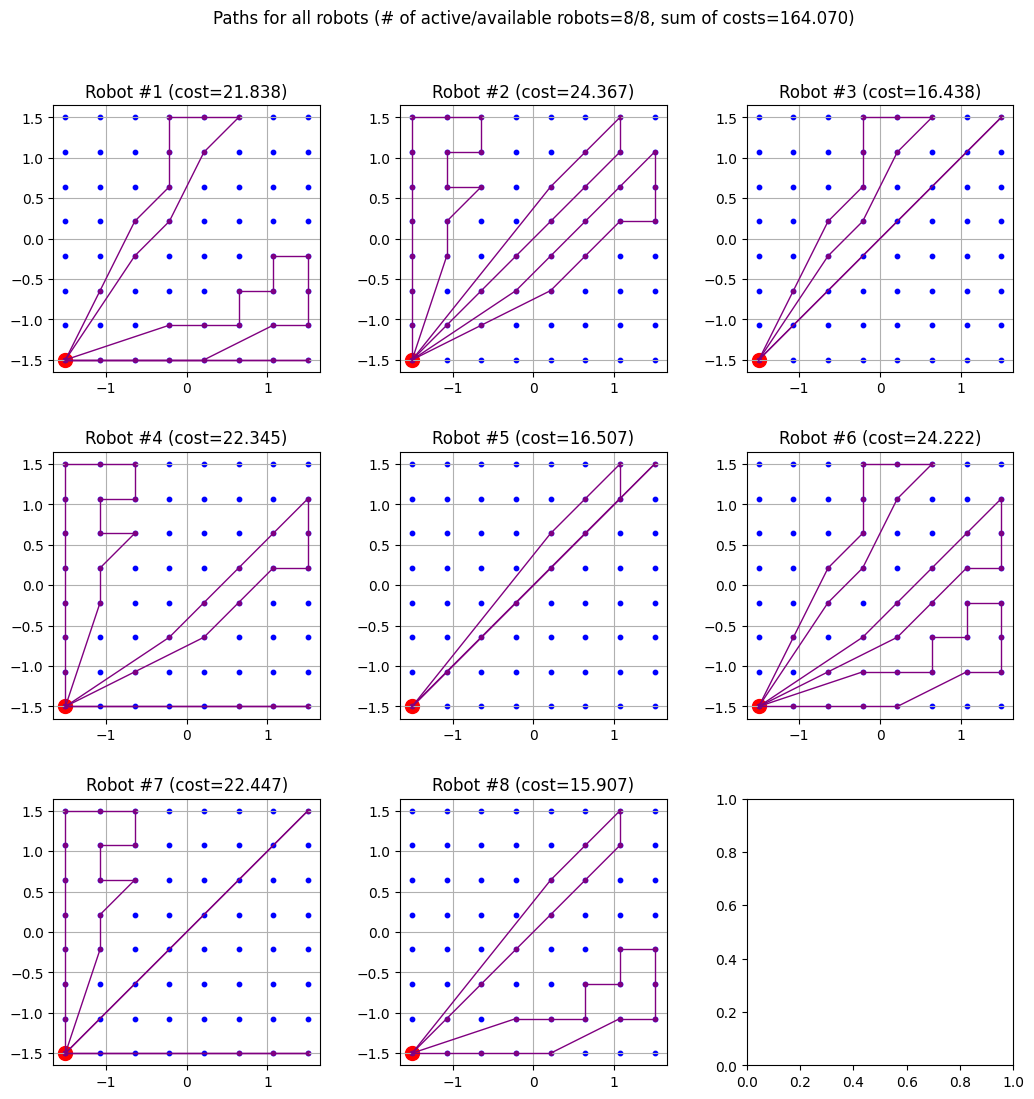

[[[-1.50000000e+00 -1.50000000e+00  0.00000000e+00]
  [-1.48000000e+00 -1.50000000e+00  0.00000000e+00]
  [-1.46000000e+00 -1.50000000e+00  1.00000000e-01]
  ...
  [-1.13077477e+00 -9.46162155e-01  3.59980000e+03]
  [-1.14186877e+00 -9.62803161e-01  3.59990000e+03]
  [-1.15296278e+00 -9.79444167e-01  3.60000000e+03]]

 [[-1.50000000e+00 -1.50000000e+00  0.00000000e+00]
  [-1.50000000e+00 -1.48000000e+00  0.00000000e+00]
  [-1.50000000e+00 -1.46000000e+00  1.00000000e-01]
  ...
  [ 1.52534805e-01  5.65668507e-01  3.59980000e+03]
  [ 1.40040904e-01  5.50051131e-01  3.59990000e+03]
  [ 1.27547004e-01  5.34433754e-01  3.60000000e+03]]

 [[-1.50000000e+00 -1.50000000e+00  0.00000000e+00]
  [-1.48585786e+00 -1.48585786e+00  0.00000000e+00]
  [-1.47171573e+00 -1.47171573e+00  1.00000000e-01]
  ...
  [ 3.43931012e-01  1.20107387e+00  3.59980000e+03]
  [ 3.29788877e-01  1.18693173e+00  3.59990000e+03]
  [ 3.15646741e-01  1.17278960e+00  3.60000000e+03]]

 ...

 [[-1.50000000e+00 -1.50000000e+00

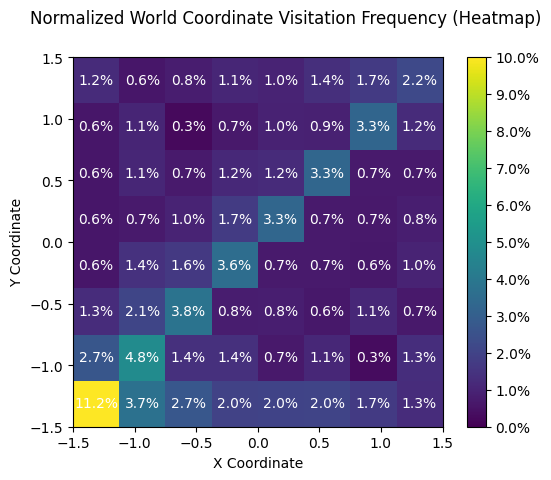

Visualizing coverage over time
average_coverage=20.686636019369832
Visualizations complete! Returning metadata...


{'mode': 'h1',
 'v': 0.2,
 't': 3600.0,
 'dt': 0.1,
 'lookback_time': 5.0,
 'opt_node_path_costs': [21.837746371178923,
  24.36698252728338,
  16.43802247213113,
  22.345482783104405,
  16.506781118417543,
  24.22187577319412,
  22.44663475532777,
  15.906505017465335],
 'k': 8,
 'n_a': 8,
 'ssd': 3.0,
 'average_coverage': 20.686636019369832}

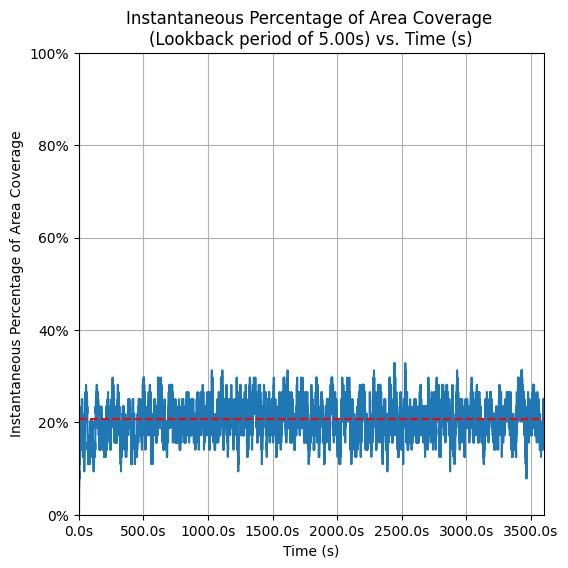

In [11]:
metadata = {"mode": "h1",
            "v": 0.2,
            "t": 3600.,
            "dt": 0.1,
            "lookback_time": 5.,
            "opt_node_path_costs": opt_node_path_costs,
            "k": min(k, len(opt_node_paths)),
            "n_a": n,
            "ssd": d}
run_visualization_pipeline(opt_node_paths, opt_world_paths, metadata)
